# Import the necessary libraries

In [1]:
#Import the necessary libraries
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# Load and Prepare the Dataset

In [2]:
from datasets import load_dataset, DatasetDict

# Define the path to your local dataset directory
data_dir = "/kaggle/input/common-voice"  # Update this to the actual path
# Load the datasets using the data_files parameter
common_voice = DatasetDict()

common_voice["train"] = load_dataset(
    "csv", data_files={
        "train": [
            f"{data_dir}/cv-valid-train.csv",
            f"{data_dir}/cv-other-train.csv"
        ]
    },
    split="train"
)

common_voice["validation"] = load_dataset(
    "csv", data_files={
        "validation": [
            f"{data_dir}/cv-valid-dev.csv",
            f"{data_dir}/cv-other-dev.csv"
        ]
    },
    split="validation"
)

common_voice["test"] = load_dataset(
    "csv", data_files={
        "test": [
            f"{data_dir}/cv-valid-test.csv",
            f"{data_dir}/cv-other-test.csv"
        ]
    },
    split="test"
)


print(common_voice)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 340911
    })
    validation: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 7098
    })
    test: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 6956
    })
})


In [3]:
# Accessing the first sample in the train split
first_sample = common_voice["train"][0]
first_sample

{'filename': 'cv-valid-train/sample-000000.mp3',
 'text': 'learn to recognize omens and follow them the old king had said',
 'up_votes': 1,
 'down_votes': 0,
 'age': None,
 'gender': None,
 'accent': None,
 'duration': None}

## Correct the audio file path

In [4]:
# Function to prepend data_dir to the filename
def add_data_dir(example):
    files=example['filename'].split('/')
    example["filename"] = data_dir + '/'+files[0]+'/' + example["filename"]
    return example

# Apply the function to the train, validation, and test splits
common_voice["train"] = common_voice["train"].map(add_data_dir)
common_voice["validation"] = common_voice["validation"].map(add_data_dir)
common_voice["test"] = common_voice["test"].map(add_data_dir)

# Check the updated dataset
print(common_voice)

Map:   0%|          | 0/340911 [00:00<?, ? examples/s]

Map:   0%|          | 0/7098 [00:00<?, ? examples/s]

Map:   0%|          | 0/6956 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 340911
    })
    validation: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 7098
    })
    test: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 6956
    })
})


### Select only Audio and Text files

In [5]:
common_voice = common_voice.select_columns(["filename", "text"])
common_voice

DatasetDict({
    train: Dataset({
        features: ['filename', 'text'],
        num_rows: 340911
    })
    validation: Dataset({
        features: ['filename', 'text'],
        num_rows: 7098
    })
    test: Dataset({
        features: ['filename', 'text'],
        num_rows: 6956
    })
})

# Load Display and Lissten any random audio file

Audio Array : [ 5.74358096e-12 -1.27488384e-11 -1.11860217e-11 ...  4.40745850e-07
 -3.53286993e-07  2.32241550e-08]
Sampling Rate : 22050


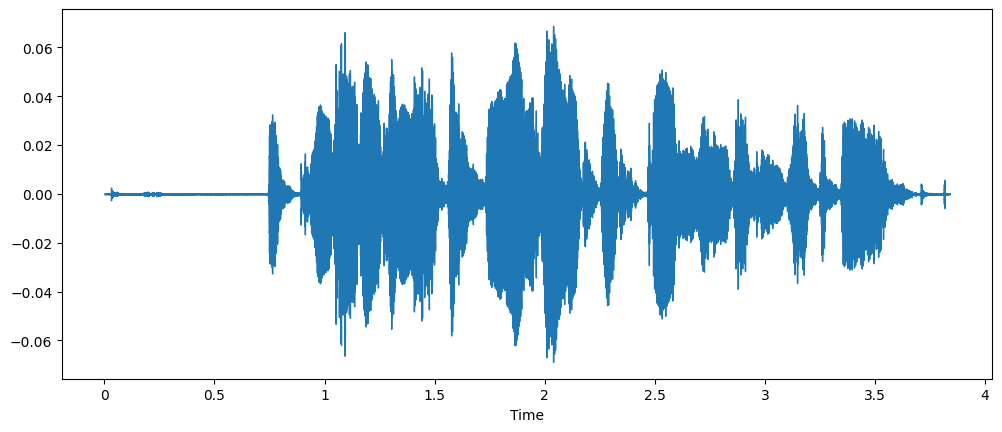


Listen the Audio File
Transcriptions : it considers the horizontal dimension as time


In [6]:
# Accessing a random sample from the train dataset

# Get a random index from the train dataset
random_index = random.randint(0, len(common_voice["train"]) - 1)
sample = common_voice["train"][random_index]

# Load and display the audio
audio_array, sampling_rate = librosa.load(sample['filename'])
print('Audio Array :', audio_array)
print('Sampling Rate :',sampling_rate)

plt.figure().set_figwidth(12)
librosa.display.waveshow(audio_array, sr=sampling_rate)
plt.show()

# Listen the audio files
from IPython.display import Audio as aud
print('\nListen the Audio File')
print('Transcriptions :',sample['text'])
aud(audio_array, rate=16_000)

## Mel spectrogram of an audio signal
It takes several parameters:
- y: The audio signal array.
- sr: The sampling rate of the audio signal.
- n_mels: The number of Mel frequency bins to generate in the spectrogram.
- fmax: The highest frequency (in Hz) to include in the spectrogram. Frequencies above this value will be discarded.

The librosa.power_to_db function converts a power spectrogram (like the Mel spectrogram) to decibels (dB) scale. It takes the spectrogram as input and computes the logarithm of the magnitudes with a reference point. In this case, ref=np.max scales the logarithmic values with respect to the maximum value in the input spectrogram.

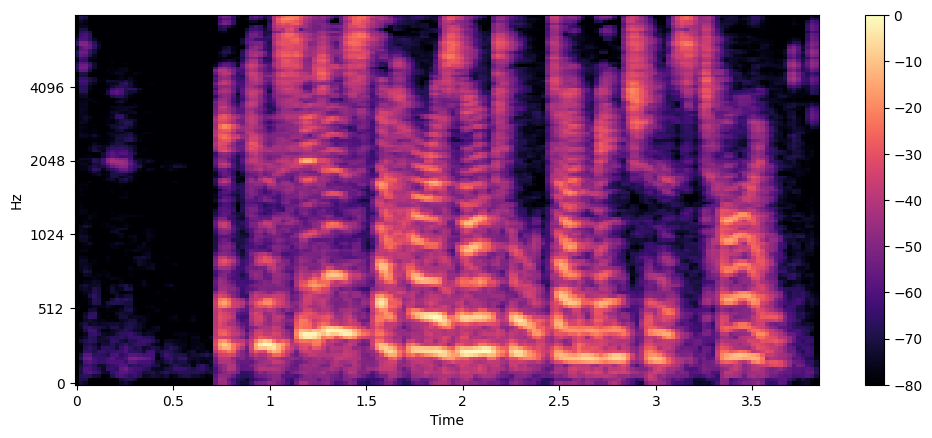

In [7]:
# Mel spectrogram of an audio signal
spectrogram = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate,
                                   n_mels=128, fmax=8_000)

# Mel spectrogram of an audio signal
spectrogram = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate,
                                   n_mels=128, fmax=8_000)
# converts a power spectrogram S to decibels (dB) scale
decibels_scale = librosa.power_to_db(spectrogram, ref=np.max)

plt.figure().set_figwidth(12)

librosa.display.specshow(decibels_scale, 
                         x_axis="time", y_axis="mel", 
                         sr=sampling_rate,
                         fmax=8000)

plt.colorbar()
plt.show()

# Data Preprocessing
The ASR pipeline can be de-composed into three stages:

* The feature extractor which pre-processes the raw audio-inputs to log-mel spectrograms
* The model which performs the sequence-to-sequence mapping
* The tokenizer which post-processes the predicted tokens to text

In [8]:
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE

len(TO_LANGUAGE_CODE)

112

## Load the whisper Preprocessor

In [9]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="english",task="transcribe"
)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Pre-Process the Data

In [10]:
print(common_voice["train"].features)
sampling_rate = processor.feature_extractor.sampling_rate
print('Sampling Rate :',sampling_rate)

{'filename': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
Sampling Rate : 16000


In [11]:
# Function to preprocess audio data using WhisperProcessor
def prepare_dataset(sample):
    audio_array, sampling_rate = librosa.load(sample['filename'], 
                                              sr=processor.feature_extractor.sampling_rate)
    example = processor(audio_array, 
                       sampling_rate=sampling_rate,
                       text=sample["text"],
                       return_tensors="pt")
    # compute input length of audio sample in seconds
    #example["input_length"] = len(audio_array) / sampling_rate
    return example

In [12]:
inputs = prepare_dataset(sample)
print('Audio files  :',inputs['input_features'])
print('Text vector  :',inputs['labels'])
#print('Input length :',inputs['input_length'])

2024-06-20 09:37:48.045486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:37:48.045593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:37:48.186275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Audio files  : tensor([[[-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473],
         [-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473],
         [-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473],
         ...,
         [-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473],
         [-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473],
         [-1.1473, -1.1473, -1.1473,  ..., -1.1473, -1.1473, -1.1473]]])
Text vector  : tensor([[50258, 50259, 50359, 50363,   270, 33095,   264, 12750, 10139,   382,
           565, 50257]])


In [13]:
max_input_length = 30.0

def is_audio_in_length_range(length):
    return length < max_input_length

# Load the Whisper Model

In [14]:
from transformers import WhisperForConditionalGeneration

# Load the pre-trained Whisper model
model_name = "openai/whisper-small"
model = WhisperForConditionalGeneration.from_pretrained(model_name)

# Assuming model is on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [15]:
# Get a random index from the train dataset
random_index = random.randint(0, len(common_voice["train"]) - 1)
sample = common_voice["train"][random_index]

inputs = prepare_dataset(sample)

original_transcription = processor.decode(inputs['labels'][0],skip_special_tokens=True)
print('Original Transcription:',original_transcription)

# Generate text based on input features
outputs = model.generate(inputs['input_features'].to(device), max_length=50, num_return_sequences=1)

generated_transcription = processor.decode(outputs[0],skip_special_tokens=True)
print('\nGenerated Transcription:',generated_transcription)

# Listen the Audio
# Convert the encoded audio back to waveform using librosa
decoded_audio = processor.feature_extractor.sampling_rate * librosa.feature.inverse.mel_to_audio(
    inputs['input_features'].numpy()[0], sr=sampling_rate
)
print("\nListen the Audio")
# Display the audio using IPython.display.Audio
display(Audio(decoded_audio, rate=sampling_rate))

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Original Transcription: she don't know where laurence is

Generated Transcription:  You don't know where Lawrence is.

Listen the Audio


# Evaluate the model

In [16]:
from torchmetrics.text import WordErrorRate
wer = WordErrorRate()

In [17]:
# Initialize variables to calculate WER
total_wer = 0
num_samples = len(common_voice['validation'])

for sample in tqdm(common_voice['validation']):
    inputs = prepare_dataset(sample)

    # Decode the original transcription
    original_transcription = sample['text']
    
    # Generate text based on input features
    outputs = model.generate(inputs['input_features'].to(device), max_length=50, num_return_sequences=1)
    generated_transcription = processor.decode(outputs[0], skip_special_tokens=True)

    # Calculate WER
    wer_score = wer(original_transcription, generated_transcription)
    total_wer += wer_score
                                               
# Calculate the average WER for the entire dataset
average_wer = total_wer / num_samples
print(f'Average WER for the training dataset: {average_wer}')

100%|██████████| 7098/7098 [37:28<00:00,  3.16it/s]

Average WER for the training dataset: 0.42634981870651245


# Save the model

In [18]:
# Define the directory where you want to save the model
save_directory = '/kaggle/working/saved_model'

# Save the model to the specified directory
model.save_pretrained(save_directory)

# Optionally, save the tokenizer if needed
# tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


Model saved to /kaggle/working/saved_model
